## Installing libraries

In [2]:
# !pip install ipyleaflet
# !pip install pystac
# !pip install pystac_client
# !pip install rich
# !pip install odc.stac
# !pip install planetary_computer
# !pip install geopandas
# !pip install xgboost

## Importing Libraries and Dataset

In [3]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor


# Planetary Computer Tools
import pystac
import pystac_client
# import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
pc.settings.set_subscription_key('70f3348ff9af45168b72f35a0a9b2d8b')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import xarray as xr
import geopandas
import ast

In [4]:
crop_yield_data = pd.read_csv("./Crop_Yield_Data_challenge_2.csv")
crop_yield_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


In [5]:
crop_yield_data.shape

(557, 8)

## Fetching Data from API

In [6]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [7]:
def get_sentinel_data(longitude, latitude, season,assests):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    bands_of_interest = assests
    if season == 'SA':
        time_slice = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_slice = "2022-01-01/2022-04-30"
        
    red_list=[]
    green_list=[]
    nir_list=[]
    rededge_list = []
    swir_list = []

    bbox_of_interest = [longitude , latitude, longitude, latitude]
    time_of_interest = time_slice

    search = catalog.search(collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_of_interest)
    
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()

    data = stac_load([items[1]],bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest,crs="EPSG:4326",
    resolution=0.00009009).isel(time=0)

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest,crs="EPSG:4326",
        resolution=0.00009009).isel(time=0)
        data = data.where(~data.isnull(), 0)
        red = data["red"].astype("float64")
        green = data["green"].astype("float64")
        nir = data["nir"].astype("float64")
        red_edge = data["rededge"].astype("float64")
        swir = data["swir16"].astype("float64")

        red_list.append(np.median(red))
        green_list.append(np.median(green))
        nir_list.append(np.median(nir))
        rededge_list.append(np.median(red_edge))
        swir_list.append(np.median(swir))
              
    return red_list, green_list, nir_list, rededge_list, swir_list

In [8]:
def get_sentinel_data_vv(longitude, latitude, season,assests):
    
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    
    '''
    
    bands_of_interest = assests
    if season == 'SA':
        time_slice = "2022-05-01/2022-08-31"
    if season == 'WS':
        time_slice = "2022-01-01/2022-04-30"
        
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    
    bbox_of_interest = [longitude , latitude, longitude, latitude]
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    item = items[0]
    items.reverse()

    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest,crs="EPSG:4326",
        resolution=0.00009009).isel(time=0)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))
              
    return vv_list, vh_list, vv_by_vh_list

In [9]:
def create_band_df(df):
  ## Get Sentinel-1-RTC Data
#   assests = ['red','green','nir','rededge','swir16']
#   train_band_values = df.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
#   red = [x[0] for x in train_band_values]
#   green = [x[1] for x in train_band_values]
#   nir = [x[2] for x in train_band_values]
#   rededge = [x[3] for x in train_band_values]
#   swir = [x[4] for x in train_band_values]
#   band_df = pd.DataFrame(list(zip(red,green,nir,rededge,swir)),columns = ["red","green","nir","rededge","swir"])
#   band_df['red'] = red
#   band_df['green'] = green
#   band_df['nir'] = nir
#   band_df['rededge'] = rededge
#   band_df['swir'] = swir
#   band_df.to_csv("band_df.csv") #to csv
  band_df = pd.read_csv('band_df.csv')
  band_df = band_df.iloc[:,1:]
  # print(band_df.head())

#   assests = ['vh','vv']
#   train_band_values = df.progress_apply(lambda x: get_sentinel_data_vv(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
#   vh = [x[0] for x in train_band_values]
#   vv = [x[1] for x in train_band_values]
#   vv_by_vh = [x[2] for x in train_band_values]
#   vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh)),columns = ["vv_list","vh_list","vv_by_vh"])
#   vh_vv_data['vv_list'] = vv
#   vh_vv_data['vh_list'] = vh
#   vh_vv_data['vv_by_vh'] = vv_by_vh
#   vh_vv_data.to_csv("vh_vv.csv") #to csv
  vh_vv_data = pd.read_csv('vh_vv.csv')
  vh_vv_data = vh_vv_data.iloc[:,1:]

  crop_data = pd.concat([band_df, vh_vv_data],axis=1)
  crop_data.columns = ['vv','vh','vv/vh','red','green','nir','rededge','swir']

  return crop_data


## Feature Engineering

In [10]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [11]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [12]:
def generate_stastical_features(df):
  for col in df.columns:
    min_list = []
    max_list = []
    range_list = []
    mean_list = []
    correlation_list = []
    # premutation_entropy_list = []
    for i in range(len(df[col])):
      # print(len(col))
      cell = df.at[i,col]
      if type(cell)==str:
        cell = ast.literal_eval(cell)
      min_list.append(min(cell))
      max_list.append(max(cell))
      range_list.append(max_list[-1]-min_list[-1])
      mean_list.append(np.mean(cell))
      # correlation_list.append(sm.tsa.acf(cell)[1])
      # premutation_entropy_list.append(permutation_entropy(cell, dx=6,base=2, normalized=True)) 
  
    df[col+'_min'] = min_list
    df[col+'_max'] = max_list
    df[col+'_range'] = range_list
    df[col+'_mean'] = mean_list
    # df[col+'_correlation'] = correlation_list
    # df[col+'_permutation_entropy'] = premutation_entropy_list
    df.drop(col,axis=1,inplace=True)
    

  return df

In [13]:
def generate_indices(df):
  # df['NDVI_min'] = (df['nir_min'] - df['red_min'])/(df['nir_min']+df['red_min'])
  # df['NDVI_max'] = (df['nir_max'] - df['red_max'])/(df['nir_max']+df['red_max'])
  df['NDVI_mean'] = (df['nir_mean'] - df['red_mean'])/(df['nir_mean']+df['red_mean'])

  # df['GNDVI_min'] = (df['nir_min']-df['green_min']) / (df['NDVI_min']+df['green_min'])
  # df['GNDVI_max'] = (df['nir_max']-df['green_max']) / (df['NDVI_max']+df['green_max'])
  df['GNDVI_mean'] = (df['nir_mean']-df['green_mean']) / (df['NDVI_mean']+df['green_mean'])

  # df['NDRE_min'] = (df['nir_min'] - df['rededge_min']) / (df['nir_min'] + df['rededge_min'])
  # df['NDRE_max'] = (df['nir_max'] - df['rededge_max']) / (df['nir_max'] + df['rededge_max'])
  df['NDRE_mean'] = (df['nir_mean'] - df['rededge_mean']) / (df['nir_mean'] + df['rededge_mean'])

  # df['NDWI_min'] = (df['nir_min'] - df['swir_min']) / (df['nir_min'] + df['swir_min'])
  # df['NDWI_max'] = (df['nir_max'] - df['swir_max']) / (df['nir_max'] + df['swir_max'])
  df['NDWI_mean'] = (df['nir_mean'] - df['swir_mean']) / (df['nir_mean'] + df['swir_mean'])

  # Calculate RVI
  dop = (df['vv_mean'] / (df['vv_mean'] + df['vh_mean']))
  m = 1 - dop
  rvi = (np.sqrt(dop))*((4*df['vh_mean'])/(df['vv_mean'] + df['vh_mean']))
  df['RVI_mean'] = rvi

  # dop = (df['vv_min'] / (df['vv_min'] + df['vh_min']))
  # m = 1 - dop
  # rvi = (np.sqrt(dop))*((4*df['vh_min'])/(df['vv_min'] + df['vh_min']))
  # df['RVI_min'] = rvi

  # dop = (df['vv_max'] / (df['vv_max'] + df['vh_max']))
  # m = 1 - dop
  # rvi = (np.sqrt(dop))*((4*df['vh_max'])/(df['vv_max'] + df['vh_max']))
  # df['RVI_max'] = rvi

  return df

## Preparing data for ml model

In [14]:
def update_crop_yield_train(df):
  df.columns = ['District','Lat','Long','Season','Intensity','Date','Field Size','Rice Yield']
  df['Intensity'].replace({'T':1,'D':0},inplace=True)
  df['Season'].replace({'SA':1,'WS':0},inplace=True)
  dummies = pd.get_dummies(df['District'])
  df = df.drop(['Lat','Long','District','Date'],axis=1)
  df = pd.concat([dummies,df],axis=1)
  return df

In [15]:
def update_crop_yield_test(df):
  df.columns = ['District','Lat','Long','Season','Intensity','Date','Field Size']
  df['Intensity'].replace({'T':1,'D':0},inplace=True)
  df['Season'].replace({'SA':1,'WS':0},inplace=True)
  dummies = pd.get_dummies(df['District'])
  df = df.drop(['Lat','Long','District','Date'],axis=1)
  df = pd.concat([dummies,df],axis=1)
  return df

## Pipeline

In [16]:
def pipeline(df):
  df1=df
  df = create_band_df(df)
  df = generate_stastical_features(df)
  df = generate_indices(df)
  if(df1.shape[1]==8):
    df1 = update_crop_yield_train(df1)
  elif(df1.shape[1]==7):
    df1 = update_crop_yield_test(df1)
  df = pd.concat([df1,df],axis=1)

  return df

In [17]:
df = pipeline(crop_yield_data)

In [18]:
# df.head()
df.shape

(557, 44)

## Train Test Split

In [19]:
x = df.drop('Rice Yield',axis=1).values
y = df['Rice Yield'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=25)


In [20]:
# len(x_test)
# len(x_train)

## Model Training


In [21]:
regressor = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion="absolute_error",
                    max_depth=8, max_features='auto', max_leaf_nodes=100,
                    max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=True)


In [22]:
regressor.fit(x_train, y_train)

ExtraTreesRegressor(criterion='absolute_error', max_depth=8,
                    max_features='auto', max_leaf_nodes=100, n_jobs=-1,
                    random_state=123, warm_start=True)

In [23]:
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [24]:
xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(xgb, x_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 429.953 (55.844)


In [25]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

## Model Evaluation

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [27]:
def model_evaluation(model):
    insample_predictions = model.predict(x_train)
    print("Insample R2 Score: {0:.2f}".format(r2_score(y_train,insample_predictions)))
    outsample_predictions = model.predict(x_test)
    print("Outsample R2 Score: {0:.2f}".format(r2_score(y_test,outsample_predictions)))
    print("Accuracy: {0:.2f}".format(r2_score(y_test,outsample_predictions)*100))
    print("MSE: {0:.2f}".format(mean_squared_error(y_test,outsample_predictions)))
    print("RMSE: {0:.2f}".format(mean_squared_error(y_test,outsample_predictions,squared=False)))
    print("MAE: {0:.2f}".format(mean_absolute_error(y_test,outsample_predictions)))

In [28]:
model_evaluation(regressor)

Insample R2 Score: 0.80
Outsample R2 Score: 0.63
Accuracy: 62.68
MSE: 216413.42
RMSE: 465.20
MAE: 362.44


In [29]:
model_evaluation(xgb)

Insample R2 Score: 1.00
Outsample R2 Score: 0.58
Accuracy: 58.42
MSE: 241140.22
RMSE: 491.06
MAE: 398.45


## random forest

In [30]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

In [31]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [32]:
y_pred = rf.predict(x_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.2857142857142857


In [34]:
model_evaluation(rf)

Insample R2 Score: 1.00
Outsample R2 Score: 0.32
Accuracy: 31.82
MSE: 395380.95
RMSE: 628.79
MAE: 469.76


### more model

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [36]:
sc = StandardScaler()
X_train_std = sc.fit_transform(x_train)
X_test_std = sc.transform(x_test)

In [37]:
# Hyperparameters for GradientBoostingRegressor
gbr_params = {'n_estimators': 1000,
        'max_depth': 3,
        'min_samples_split': 5,
        'learning_rate': 0.01,
        'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor()
#
# Fit the model
#
gbr.fit(X_train_std, y_train)

GradientBoostingRegressor()

In [38]:
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.570
The mean squared error (MSE) on test set: 249454.5279


In [39]:
model_evaluation(gbr)

Insample R2 Score: -0.35
Outsample R2 Score: -0.94
Accuracy: -94.06
MSE: 1125386.46
RMSE: 1060.84
MAE: 877.95


In [40]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0)

# fit the regressor with X and Y data
regressor.fit(x_train, y_train)


DecisionTreeRegressor(random_state=0)

In [41]:
model_evaluation(regressor)

Insample R2 Score: 1.00
Outsample R2 Score: 0.17
Accuracy: 17.26
MSE: 479821.43
RMSE: 692.69
MAE: 557.98


In [42]:
df

,Chau_Phu,Chau_Thanh,Thoai_Son,Season,Intensity,Field Size,Rice Yield,vv_min,vv_max,vv_range,...,rededge_mean,swir_min,swir_max,swir_range,swir_mean,NDVI_mean,GNDVI_mean,NDRE_mean,NDWI_mean,RVI_mean
0,1,0,0,1,1,3.40,5500,1273.0,6392.0,5119.0,...,0.112290,0.555078,29.989193,29.434115,6.771513,-0.999986,-1.000313,-0.660134,-0.993233,1.442495
1,1,0,0,1,1,2.43,6000,1814.0,14408.0,12594.0,...,0.166436,1.580250,7.805157,6.224906,4.583483,-0.999979,-1.000292,-0.626402,-0.983456,1.425787
2,1,0,0,1,0,1.95,6400,1142.0,13616.0,12474.0,...,0.180863,0.691084,36.552106,35.861022,8.106786,-0.999983,-1.000310,-0.689930,-0.991846,1.429156
3,1,0,0,1,1,4.30,6000,1256.0,9112.0,7856.0,...,0.116675,1.664036,28.349087,26.685050,7.416280,-0.999988,-1.000258,-0.643147,-0.993190,1.440828
4,1,0,0,1,0,3.30,6400,1196.0,9488.0,8292.0,...,0.169892,1.338847,29.232963,27.894115,6.989110,-0.999983,-1.000272,-0.672745,-0.990534,1.437955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,0,0,1,0,1,7.80,6640,1038.0,15880.0,14842.0,...,0.158147,0.779565,98.074750,97.295186,12.486594,-0.999988,-1.000259,-0.712859,-0.995763,1.445993
553,0,0,1,0,1,2.00,7200,886.0,12960.0,12074.0,...,0.098319,0.636856,37.638900,37.002044,8.249236,-0.999983,-1.000298,-0.556032,-0.993222,1.445682
554,0,0,1,0,1,6.20,7200,429.0,7424.0,6995.0,...,0.159663,1.976414,14.471199,12.494785,5.070588,-0.999974,-1.000297,-0.580868,-0.983442,1.442218
555,0,0,1,0,1,3.00,6400,192.0,8784.0,8592.0,...,0.110304,0.852697,22.231642,21.378945,5.848876,-0.999985,-1.000290,-0.614705,-0.991040,1.448973


In [47]:
import collections
collections.Counter(df['Rice Yield'])

Counter({5500: 59,
         6000: 78,
         6400: 67,
         6600: 7,
         6500: 26,
         6800: 25,
         7200: 91,
         8000: 55,
         7040: 16,
         7600: 20,
         7760: 8,
         6880: 3,
         6960: 3,
         7920: 3,
         6700: 1,
         7000: 21,
         7400: 2,
         7500: 5,
         7900: 1,
         5600: 47,
         6240: 1,
         6160: 1,
         5440: 1,
         5200: 3,
         6520: 1,
         6640: 9,
         7440: 1,
         7840: 2})

<AxesSubplot: ylabel='Rice Yield'>

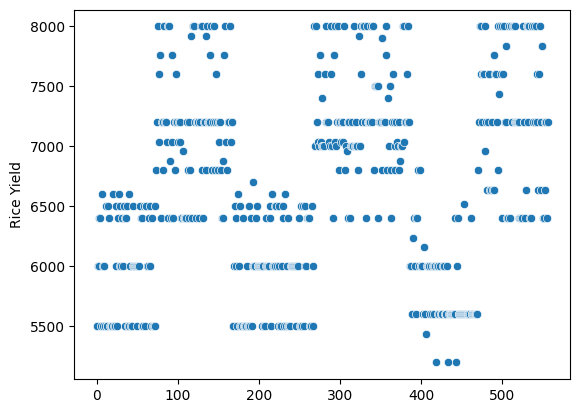

In [48]:
import seaborn as sns
sns.scatterplot(df['Rice Yield'])